## **Importing the Dependencies**

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics

#Import the different models you want to use (Note: these are for regression problems)
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Lasso

from sklearn.model_selection import cross_val_score

## **Machine Learning Development Cycle (Workflow)**

- **Business Problem Statement**
  - Define and understand the problem you are trying to solve
- **Build Data**
  - Collect the data
  - Handle missing values
  - Analyze the data
  - Feature Engineering
  - Split the data into train/validation/test
- **Train and Evaluate the Model**
  - Build and train the models using the train dataset
  - Use the validation dataset to select the best performing models
  - Use the test dataset to estimate the performance of the selected models on out of sample data
- **Deploy Model to Production**
  - Deploy the model
  - Monitor and maintain the model

## **Business Problem Statement**

---------------

## **Build the Data**

#### **Step 1:** Read the dataset and print the first 5 rows

In [ ]:
# loading the data from csv file to Pandas DataFrame - Use your own file path
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/NITDA_AI_Class/Machine_Learning/Projects/Regression/Big_Mart_Sales_Prediction/mart_data.csv')

# first 5 rows of the dataframe
data.head(5)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [ ]:
data.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.643456,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


#### **Step 2:** Check the general info about your data

- This will also tell you the number of data entries you have

- Use the information to note down the categorical columns (features), you might need it later

In [ ]:
# getting some information about the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


Categorical Features:
- Item_Identifier
- Item_Fat_Content
- Item_Type
- Outlet_Identifier
- Outlet_Size
- Outlet_Location_Type
- Outlet_Type

In [ ]:
cat_features = ['Item_Identifier','Item_Fat_Content','Item_Type','Outlet_Identifier','Outlet_Size','Outlet_Location_Type','Outlet_Type']

num_features = ['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_Establishment_Year']

#### **Step 3:** Check for Outliers and Remove if any

- Only check outliers in numerical columns

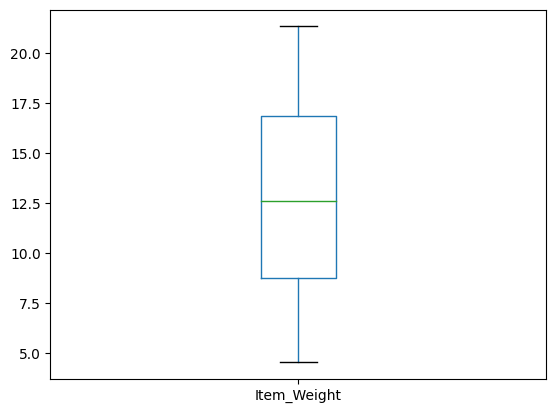

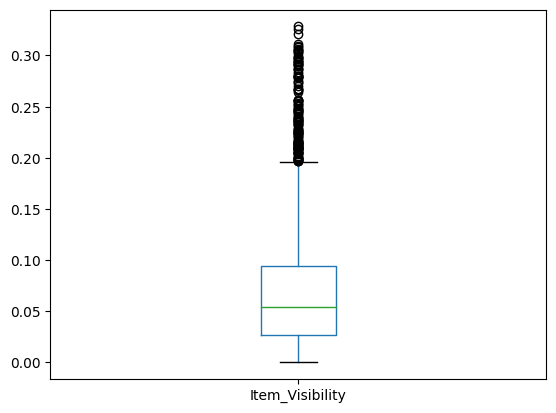

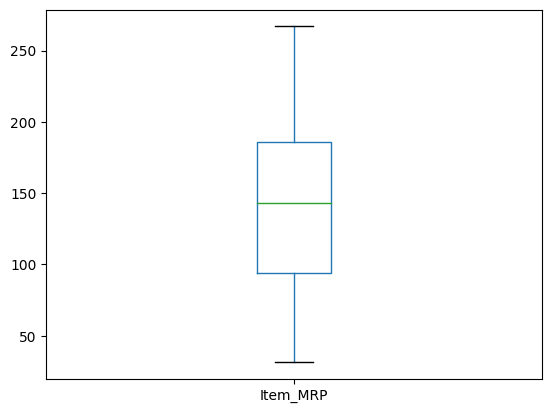

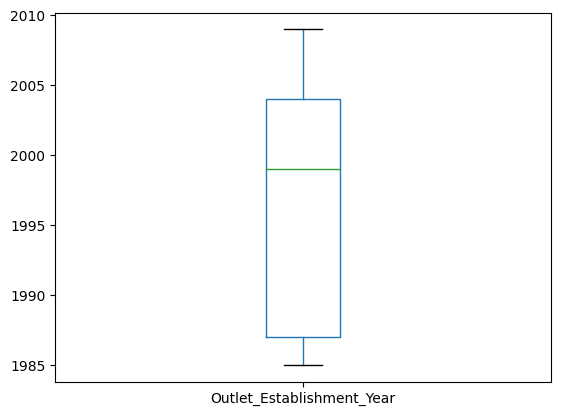

In [ ]:
#PLOT THE OUTLIERS

def plot_boxplot(df, ft):
  df.boxplot(column=[ft])
  plt.grid(False)
  plt.show()

for feat in num_features:
  plot_boxplot(data, feat)
  print("\n\n")

In [ ]:
#Create a function that returns a list containing all the index of outliers based on interquatile range
def outliers(df, ft):
  Q1 = df[ft].quantile(0.25)
  Q3 = df[ft].quantile(0.75)
  IQR = Q3 - Q1

  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR

  index_list = df.index[ (df[ft] < lower_bound) | (df[ft] > upper_bound) ]

  return index_list

# #Create an empty list to store the output indices from multiple columns
index_lists = []
for feature in num_features:
  index_list = outliers(data, feature)
  if len(index_list)>0:
    index_lists.extend(index_list)

index_lists = sorted(set(index_lists))
data = data.drop(index_lists)

#### **Step 4:** Handle missing values, if any

In [ ]:
# checking for missing values
data.isna().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

**Handling Missing Values**

Handling Numerical Features:
- Handle the missing values using either the `mean or the median` of that feature (column)
- You will generally use the `mean` with the exception of if there are outliers in your dataset, in which case you would use the `median`
- Always check for the presence of outliers before handling missing values with the mean
- You can check for outliers using the `Boxplot`

Handling Categorical Features:
- You handle missing values using `mode` of that feature
- Based on the data description, check if there might be variations in the `mode` of a feature based on another feature in your data

**Handling missing values in the `Item_Weight` column**

**NOTE:** From the boxplot, there are no data points below or above the wiskers of the plot, hence there are no outliers

In [ ]:
# calculate the mean value of "Item_Weight" column
mean_item_weight = data['Item_Weight'].mean()

# filling the missing values in "Item_weight column" with "Mean" value
data['Item_Weight'].fillna(mean_item_weight, inplace=True)

**Handling missing values in the `Outlet_Size` column**

In [ ]:
# Create a dataframe showing the mode of outlet size based of the outlet type
#, and show it
mode_of_Outlet_size = data.pivot_table(values='Outlet_Size', columns='Outlet_Type', 
                                       aggfunc=(lambda x: x.mode()[0]))

#Show the dataframe
mode_of_Outlet_size

Outlet_Type,Grocery Store,Supermarket Type1,Supermarket Type2,Supermarket Type3
Outlet_Size,Small,Small,Medium,Medium


In [ ]:
#Get the boolean version of the missing values
miss_values = data['Outlet_Size'].isnull()  

# filling the missing values in "Outlet_Size" column with Mode based on the Outlet type
data.loc[miss_values, 'Outlet_Size'] = data.loc[miss_values,'Outlet_Type'].apply(lambda x: mode_of_Outlet_size[x])

In [ ]:
# checking for missing values
data.isnull().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

#### **Step 4:** Analyze the data
- This is used when communicating your findings to the stakeholders


In [ ]:
#Check the descriptive statistics
data.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.226124,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,9.310000,0.026989,93.826500,1987.000000,834.247400
50%,12.857645,0.053931,143.012800,1999.000000,1794.331000
75%,16.000000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


**Plot the distributions of the numerical features** 

<ipython-input-15-b3831a164986>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['Item_Weight'])


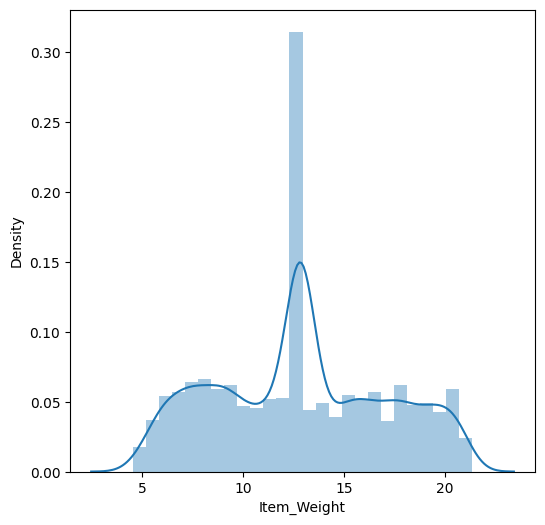

In [ ]:
# Item_Weight distribution
plt.figure(figsize=(6,6))
sns.distplot(data['Item_Weight'])
plt.show();

<ipython-input-16-278e32fd0525>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['Item_Visibility'])


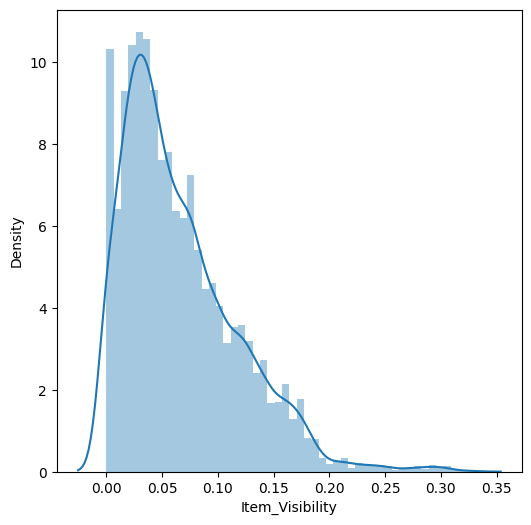

In [ ]:
# Item Visibility distribution
plt.figure(figsize=(6,6))
sns.distplot(data['Item_Visibility'])
plt.show()

<ipython-input-17-0c22b2df6b3c>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['Item_MRP'])


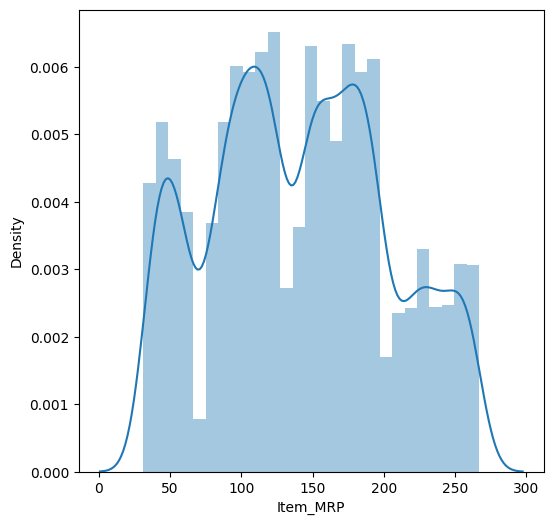

In [ ]:
# Item MRP distribution
plt.figure(figsize=(6,6))
sns.distplot(data['Item_MRP'])
plt.show()

<ipython-input-18-35eafa4ce2a4>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['Item_Outlet_Sales'])


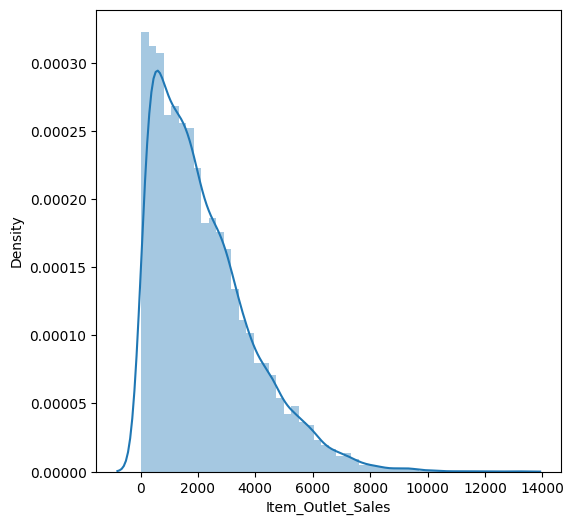

In [ ]:
# Item_Outlet_Sales distribution
plt.figure(figsize=(6,6))
sns.distplot(data['Item_Outlet_Sales'])
plt.show()

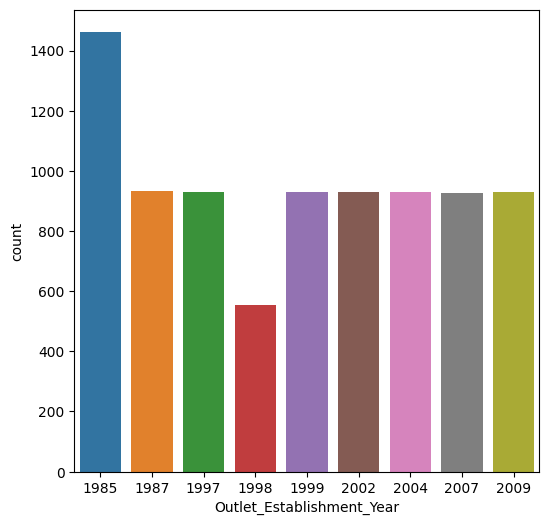

In [ ]:
# Outlet_Establishment_Year column
plt.figure(figsize=(6,6))
sns.countplot(x='Outlet_Establishment_Year', data=data)
plt.show()

**Plot the distributions of the Categorical features** 

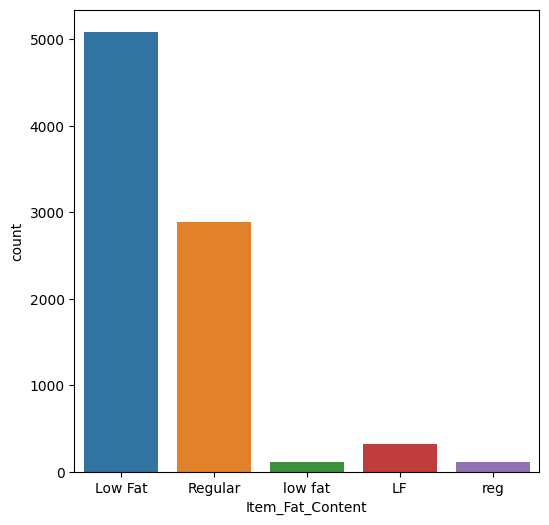

In [ ]:
# Item_Fat_Content column
plt.figure(figsize=(6,6))
sns.countplot(x='Item_Fat_Content', data=data)
plt.show()

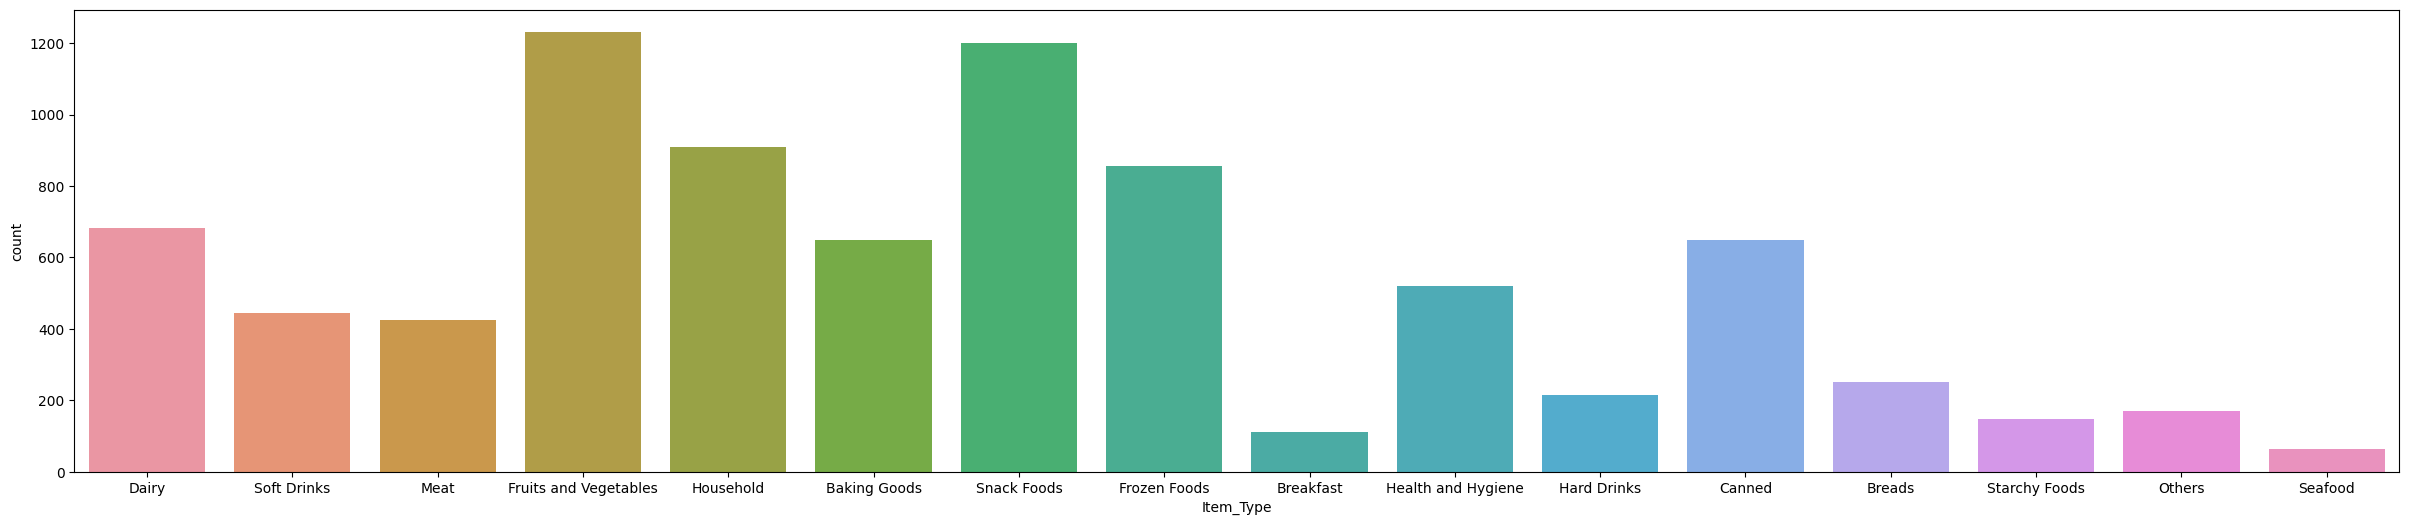

In [ ]:
# Item_Type column
plt.figure(figsize=(30,6))
sns.countplot(x='Item_Type', data=data)
plt.show()

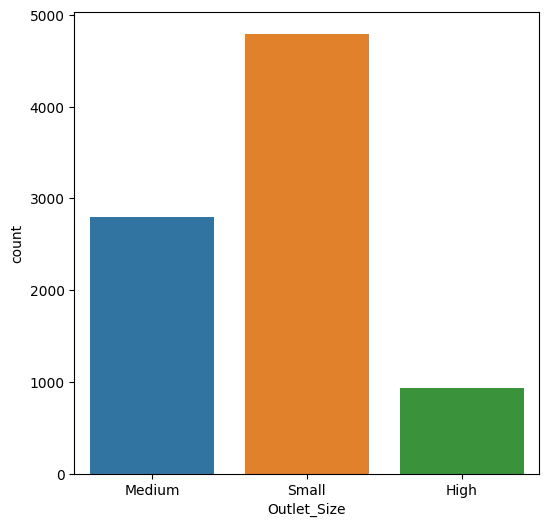

In [ ]:
# Outlet_Size column
plt.figure(figsize=(6,6))
sns.countplot(x='Outlet_Size', data=data)
plt.show()

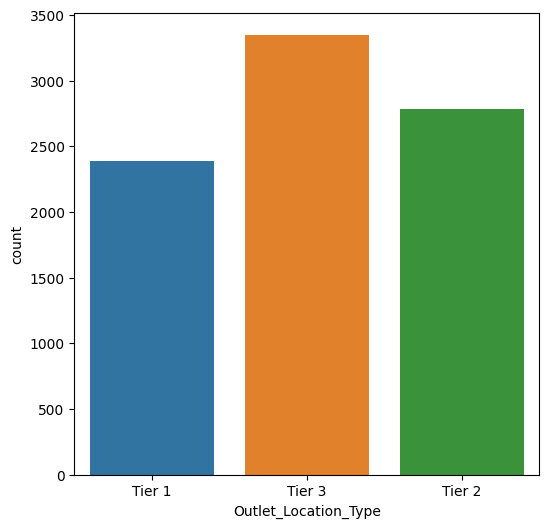

In [ ]:
# Location_Type column
plt.figure(figsize=(6,6))
sns.countplot(x='Outlet_Location_Type', data=data)
plt.show()

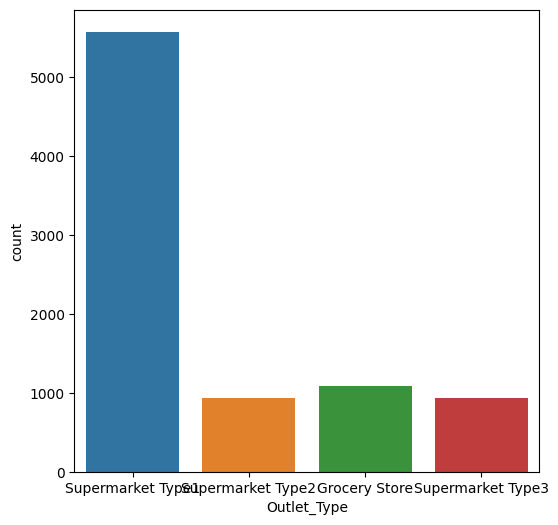

In [ ]:
#Outlet_Type
plt.figure(figsize=(6,6))
sns.countplot(x='Outlet_Type', data=data)
plt.show()

In [ ]:
# plt.figure(figsize = (8,8))
# sns.heatmap(data.corr(), annot = True);

#### **Step 5:** Feature Engineering

In [ ]:
#Check the category distribution
data['Item_Fat_Content'].value_counts()

Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64

In [ ]:
#Replace the Duplicate categories with a single category
data.replace({'Item_Fat_Content': {'low fat':'Low Fat','LF':'Low Fat', 'reg':'Regular'}}, inplace=True)

In [ ]:
data['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

**Label Encoding** 
- Use dictionary map or ordinal encoding for features that have some ordering factor
- Use one-hot encoding for norminal features (No ordering factor)
- Use label-encoding works best for targets/labels.

In [ ]:
#Create the an object of the different encoders you want to use
# Only use them on significant features

label_encoder = LabelEncoder() #Only use this for Labels/ target not features
ohe = OneHotEncoder(sparse_output = False, handle_unknown='ignore', drop='if_binary')
oe = OrdinalEncoder(categories = [['Small','Medium','High']])

In [ ]:
data[ohe.get_feature_names_out()] = ohe.fit_transform(data[['Item_Fat_Content','Outlet_Location_Type']])

data['Outlet_Size'] = oe.fit_transform(data[['Outlet_Size']])

#### **Step 6:** Select the useful features

**Check correlations**

In [ ]:
# plt.figure(figsize = (8,8))
# sns.heatmap(data.corr(), annot = True);

In [ ]:
#drop the Item_Fat_Content and Outlet_Location_Type to avoid duplicates
drop_features = ['Item_Identifier','Outlet_Identifier', 'Outlet_Type', 'Item_Weight','Outlet_Establishment_Year','Item_Type' ,'Item_Fat_Content','Outlet_Location_Type']

In [ ]:
new_data = data.drop(columns = drop_features, axis = 1 )

In [ ]:
new_data.head()

,Item_Visibility,Item_MRP,Outlet_Size,Item_Outlet_Sales,Item_Fat_Content_Regular,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3
0,0.016047,249.8092,1.0,3735.1380,0.0,1.0,0.0,0.0
1,0.019278,48.2692,1.0,443.4228,1.0,0.0,0.0,1.0
2,0.016760,141.6180,1.0,2097.2700,0.0,1.0,0.0,0.0
3,0.000000,182.0950,0.0,732.3800,1.0,0.0,0.0,1.0
4,0.000000,53.8614,2.0,994.7052,0.0,0.0,0.0,1.0


### **Step 7:** Standardize the Data

**NOTE:** Only Standardize the numerical input features

- Remember: Item_Outlet_Sales is a numerical target feature, so don't standardize it

In [ ]:
scaler = StandardScaler()
# scaler = MinMaxScaler()

In [ ]:
new_data.head(2)

,Item_Visibility,Item_MRP,Outlet_Size,Item_Outlet_Sales,Item_Fat_Content_Regular,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3
0,0.016047,249.8092,1.0,3735.1380,0.0,1.0,0.0,0.0
1,0.019278,48.2692,1.0,443.4228,1.0,0.0,0.0,1.0


In [ ]:
new_data[['Item_Visibility', 'Item_MRP']] = scaler.fit_transform(new_data[['Item_Visibility', 'Item_MRP']])

new_data.head()

,Item_Visibility,Item_MRP,Outlet_Size,Item_Outlet_Sales,Item_Fat_Content_Regular,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3
0,-0.970732,1.747454,1.0,3735.1380,0.0,1.0,0.0,0.0
1,-0.908111,-1.489023,1.0,443.4228,1.0,0.0,0.0,1.0
2,-0.956917,0.010040,1.0,2097.2700,0.0,1.0,0.0,0.0
3,-1.281758,0.660050,0.0,732.3800,1.0,0.0,0.0,1.0
4,-1.281758,-1.399220,2.0,994.7052,0.0,0.0,0.0,1.0


**Splitting the data into features & Target**

In [ ]:
X = new_data.drop(columns=['Item_Outlet_Sales'], axis=1)
Y = new_data['Item_Outlet_Sales']

In [ ]:
for col in X.columns:
  print(col)

Item_Visibility
Item_MRP
Outlet_Size
Item_Fat_Content_Regular
Outlet_Location_Type_Tier 1
Outlet_Location_Type_Tier 2
Outlet_Location_Type_Tier 3


#### **Metric : R Squared**

This is known as the coefficient of determination - It is a metric used in regression to determine the goodness of fit of the model

- It values ranges from 0 to 1, (mostly) the higher the value the better the model 

## **Model Selection: Select the best model(s) for your problem**

**Using the Train/Valid/Test Split**

- Use the training set to train the models
- Use the validation set to select the best model
- Use the test set to re-evaluate the best models

Models to be used:
- Random forest
- XGBoost regressor
- Gradient Boosting regressor
- Support Vector Regressor
- Lasso Regression

In [ ]:
#Create a 70 - 30 split of your data for the train and validation/test dataset
X_train, X_val_test, Y_train, Y_val_test = train_test_split(X, Y, test_size=0.3, random_state=0)

#Split the Validatio/test into validation and test on a ratio of 70:30
X_val, X_test, Y_val, Y_test = train_test_split(X_val_test, Y_val_test, test_size=0.3, random_state=0)

X_train.shape, Y_train.shape, X_val.shape, Y_val.shape, X_test.shape, Y_test.shape

In [ ]:
#Create a dictionary to store the names of the model and the actual model definition (or creation)
models = {'random forest':RandomForestRegressor(random_state=42),
          'gradient boosting': GradientBoostingRegressor(),
          'XGB':XGBRegressor(),
          'support vector': SVR(),
          'lasso regression': Lasso()}

In [ ]:
#Define a function to check the performace of different models 
def train_val_models(dict_, X_train,Y_train, X_val, Y_val, X_test, Y_test):

  train_scores = [] #A list to store all the training evaluation scores
  val_scores = [] #A list to store all the validation evaluation scores
  test_scores = [] #A list to store all the test evaluation scores

  for name, model in dict_.items():
    model.fit( X_train, Y_train )
    Y_train_pred = model.predict(X_train)
    Y_val_pred = model.predict(X_val)
    Y_test_pred = model.predict(X_test)
    train_score = metrics.r2_score(Y_train, Y_train_pred)
    val_score = metrics.r2_score(Y_val, Y_val_pred)
    test_score = metrics.r2_score(Y_test, Y_test_pred)
    train_scores.append(train_score)
    val_scores.append(val_score)
    test_scores.append(test_score)


  score_df = pd.DataFrame([train_scores,val_scores,test_scores], columns = list(dict_.keys())).transpose()
  score_df.rename(columns = {0:'Train', 1:'Valid', 2:'Test'}, inplace = True)

  return score_df

In [ ]:
score_df = train_val_models(models, X_train,Y_train, X_val, Y_val, X_test, Y_test)
score_df

,Train,Valid,Test
random forest,0.915913,0.384275,0.375000
gradient boosting,0.531058,0.467466,0.477772
XGB,0.790812,0.387088,0.422541
support vector,0.019880,0.006964,0.014672
lasso regression,0.391458,0.387896,0.372884


## **Limitations of Train/Valid/Test Split and the Solution**

- Metric Score tends to change depending on how the data is splitted, which makes it unreliable in-terms of estimating the model(s) performance
  - concretely, it provides a high variance estimate since changing which observations happen to be in the testing set can significantly change the testing performance

- It is unpractical to perform the Train/Valid/Test split on small dataset

### **Solution: Cross Validation**

**Understanding K-Fold Cross Validation**

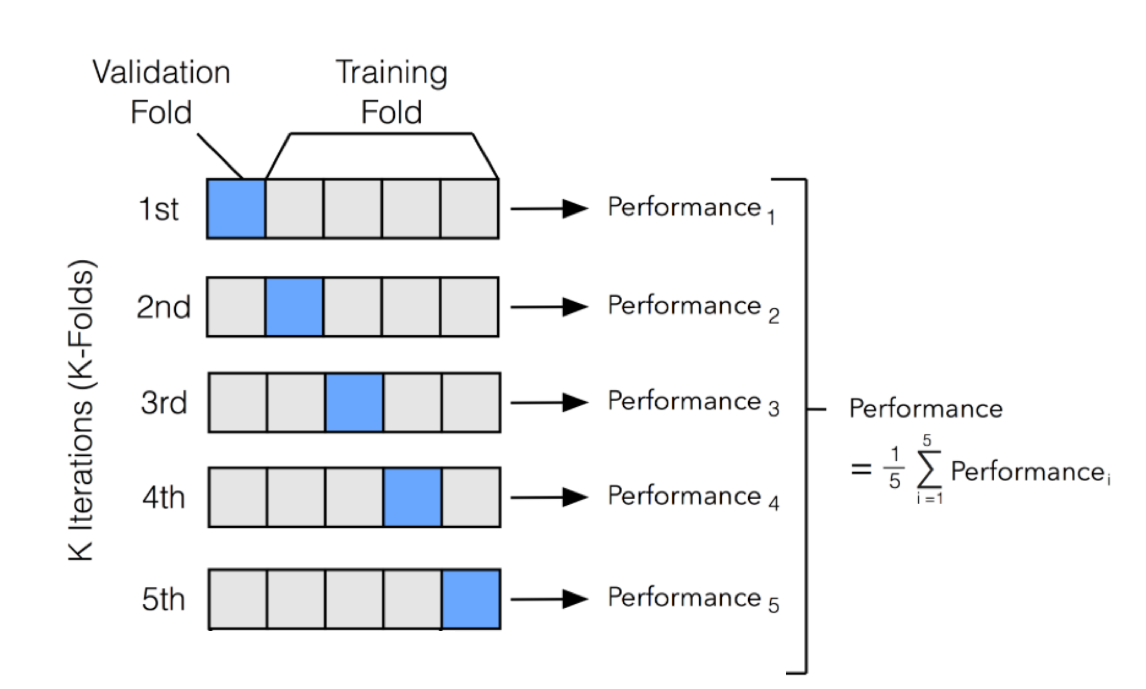

#### **Cross Validation Recommendations**

1. K can be any number, but K=10 is generally recommended
2. For classification problems, stratified sampling is recommended for creating the folds.
  - Each response class should be represented with equal proportions in each of the K folds.
  - scikit-learn's cross_val_score function does this by default

## **Implementing Cross Validation**

In [ ]:
from sklearn.model_selection import cross_val_score

In [ ]:
#Create a dictionary to store the names of the model and the actual model definition (or creation)
models = {'random forest':RandomForestRegressor(random_state=42),
          'gradient boosting': GradientBoostingRegressor(),
          'XGB':XGBRegressor(),
          'support vector': SVR(),
          'lasso regression': Lasso()}

In [ ]:
#Define a function to check the performace of different models 
def cross_val_models(model_dict, X, Y):

  cv_scores = [] #A list to store the mean performance of each model

  for name, model in model_dict.items():
    cv_score = cross_val_score(model, X, Y, cv=10, scoring='r2').mean()
    cv_scores.append(cv_score)

  score_df = pd.DataFrame([cv_scores], columns = list(model_dict.keys())).transpose()
  score_df.rename(columns = {0:'CV_Score'}, inplace = True)

  return score_df

In [ ]:
score_df = cross_val_models(models, X, Y)
score_df

,CV_Score
random forest,0.376628
gradient boosting,0.474725
XGB,0.401692
support vector,0.111888
lasso regression,0.387998


In [ ]:
#Get names of valid metrics for cross_val_score
import sklearn
sklearn.metrics.get_scorer_names()

## **Hyper-Parameter Tuning**

###**Types of Parameters**

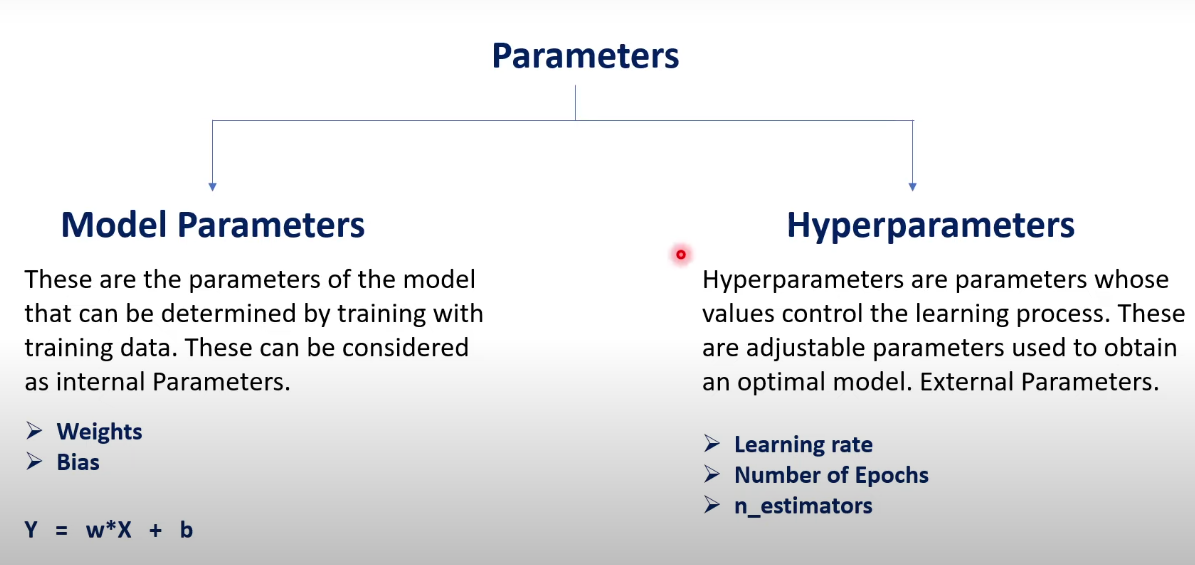

### **Hyperparameter Tuning**

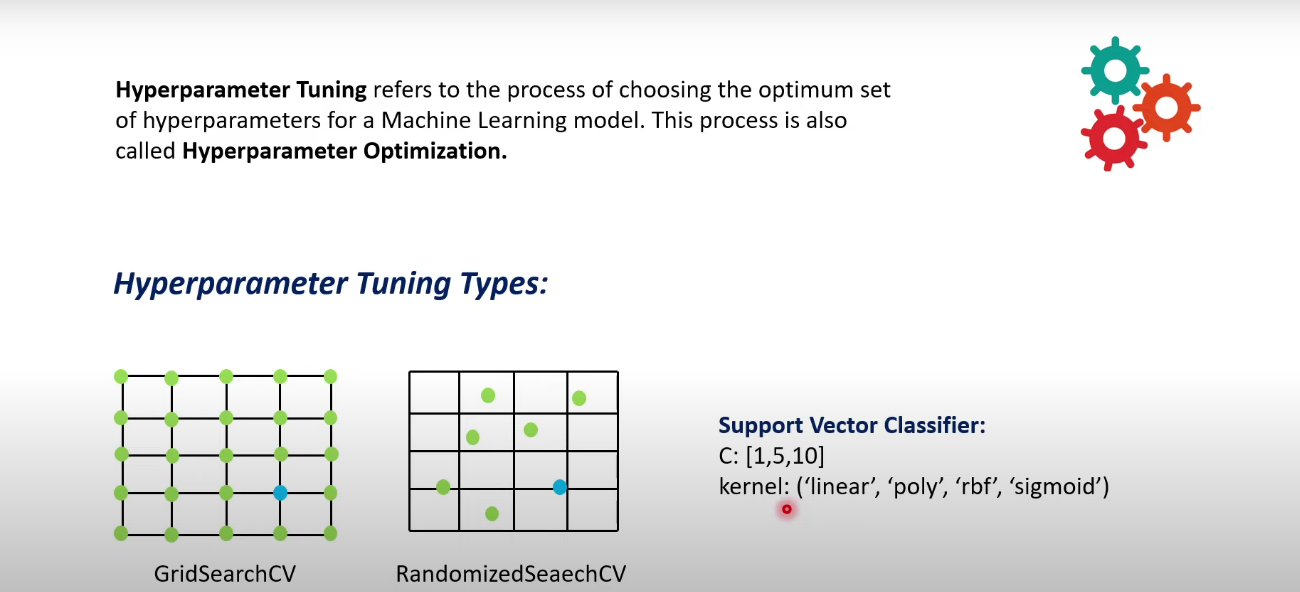

- **GridSearchCV**
- **RandomizedSearchCV**

**NOTE:** You can set `n_jobs = -1` to run computations in parallel (if supported by your computer and OS)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [ ]:
#Create a dictionary to store the names of the model and the actual model definition (or creation)
models = {'random forest':RandomForestRegressor(random_state=42),
          'gradient boosting': GradientBoostingRegressor(random_state=42)
          }

In [ ]:
params = {'random forest': 
          {
          'n_estimators': range(40, 101, 10),
          'max_depth': range(2,11,1),                  #'max_depth': [4,5,6,7,8,9]
          'min_samples_leaf': range(2,9,2),           #'min_samples_leaf': [2,3,4,5,6,7]
          },

          'gradient boosting': 
          {
          'max_depth':range(2,11,1),
          'min_samples_leaf':range(2,9,2),
          'n_estimators':range(40, 100, 10)
          }
}

In [ ]:
#Define a function to check the performace of different models 
def hyper_parameters(model_dict,param_dict, X, Y):

  best_scores = [] #A list to store the mean performance of each model
  best_params = {}

  for name, model in model_dict.items():
    # grid = GridSearchCV(model, param_dict[name], cv=10, scoring='r2')
    grid = RandomizedSearchCV(model, param_dict[name], cv=10, scoring='r2')
    grid.fit(X,Y)
    best_score = grid.best_score_
    best_param = grid.best_params_
    best_scores.append(best_score)
    best_params[name] = best_param

  score_df = pd.DataFrame([best_scores], columns = list(model_dict.keys())).transpose()
  score_df.rename(columns = {0:'Best_Score'}, inplace = True)

  return score_df,best_params

In [ ]:
score_df,best_params = hyper_parameters(models,params, X, Y)

In [ ]:
score_df

In [ ]:
pd.DataFrame(best_params)

In [ ]:
X

**Use the new parameters for cross validation**

In [ ]:
#Create a dictionary to store the names of the model and the actual model definition (or creation)
models_ = {'random forest':RandomForestRegressor(n_estimators = 40,min_samples_leaf=8, max_depth = 7,random_state=42),
          'gradient boosting': GradientBoostingRegressor(n_estimators = 70,min_samples_leaf=4, max_depth = 4, random_state=42 ),
          'XGB':XGBRegressor(),
          'support vector': SVR(),
          'lasso regression': Lasso()}

#Define a function to check the performace of different models 
def cross_val_models(model_dict, X, Y):

  cv_scores = [] #A list to store the mean performance of each model

  for name, model in model_dict.items():
    cv_score = cross_val_score(model, X, Y, cv=10, scoring='r2').mean()
    cv_scores.append(cv_score)

  score_df = pd.DataFrame([cv_scores], columns = list(model_dict.keys())).transpose()
  score_df.rename(columns = {0:'CV_Score'}, inplace = True)

  return score_df



In [ ]:
score_df = cross_val_models(models_, X, Y)
score_df

##**Ensamble Models**

## **Feature Selection**

**Techniques for selecting Features**

- **Percent of Missing Values**
  - drop variables that have a high % of missing values
- **Pairwise Correletion**
  - Many variables are often correlated with each other, hence they are redundant
  - If two variables are highly correlated, keeping only one will help reduce dimentionality without much loss of information
  - Keep the variable with the higher correlation coefficient with the target 

- **Principal Component Analysis**
  - When there is excessive multicollinearity
  - Explanation of the predictors is not important
  - More suitable for unsupervise machine learning

- **Correlation with Target**
  - Drop variables that have a very low correlation with the target 
  - If a variable has a very low correlation with the target , it's not going to be useful for model prediction.

- Tree based Algorithm (Ensemble Models)
   - Automatically compute feature importance

## **Using Pipelines**

##**Model Deployment**

**Train the Selected Model with the Optimal Hyper-Parameters**

#**Resources**

**Feature Engineering**

- Feature Encoding Techniques in Machine Learning with Python Implementation [Link](https://towardsdatascience.com/feature-encoding-techniques-in-machine-learning-with-python-implementation-dbf933e64aa)

**Cross Validation and Model Selection**

- Documentation on cross-validation: [Link](https://www.youtube.com/redirect?event=video_description&redir_token=QUFFLUhqbWRmbjZURExqRTRIaHlkc0R1bUEyd09tcEVPd3xBQ3Jtc0trQy1TRjU1NW1uUC1FWkx1aWZSa0FXc3FlMzY0VDdLV3lFc21yX0JvMkxmUlFGUktpSHIxeTA2SHVRVUtNOFNCWkpPclppT2ZZakNGcjFNZU53aFhXanVhSjNGOUhlSlJwM3UwaWdHTUtqaEJFakpJVQ&q=http%3A%2F%2Fscikit-learn.org%2Fstable%2Fmodules%2Fcross_validation.html&v=6dbrR-WymjI)
- Documentation on model evaluation:[Link](https://www.youtube.com/redirect?event=video_description&redir_token=QUFFLUhqa2pOaHB2RGtFWGNwRHYwQ29tN2pHcHZHc2U4Z3xBQ3Jtc0ttZHF3QkNSRkpvUE9hV3BRQWVGSWVxYTZ3UTcwTnhqb0tpbFJQVjJQQjFoSkQ4OFVaeVJJWkJIZnhVbWtQb3FWS3FtTFhLQS1sdVlzeW1FS09JeXhTcDFYRXZ1VTdsUkJzeHBHRFRsUUNXOFNtUHlTYw&q=http%3A%2F%2Fscikit-learn.org%2Fstable%2Fmodules%2Fmodel_evaluation.html&v=6dbrR-WymjI)
- An Introduction to Statistical Learning: [Link](https://www.youtube.com/redirect?event=video_description&redir_token=QUFFLUhqbVZIak0wcUFGSEZJTW5OZ05BdUxZZ3lKTzRIZ3xBQ3Jtc0trSXd5WkZqZkVDRWJtWXUzanl6R0Fady15X3ZVQ3pWUlhhakVsNzVnQUhEcV9lU2hNdzNEXzZJelVlOTVWNGM1YjhKZjRFOXI0SlJiTEpOaEtoYWpja0c1b3dNNzJfN0VBMnZ3eUFaY09XdEhXZ0tqQQ&q=http%3A%2F%2Fwww-bcf.usc.edu%2F%7Egareth%2FISL%2F&v=6dbrR-WymjI)

- K-fold and leave-one-out cross-validation: [Link](https://www.youtube.com/watch?v=nZAM5OXrktY&t=0s) 
- Cross-validation the right and wrong ways: [Link](https://www.youtube.com/watch?v=S06JpVoNaA0&t=0s) 

- Accurately Measuring Model Prediction Error: [Link](https://www.youtube.com/redirect?event=video_description&redir_token=QUFFLUhqbjZrRVZuVEM2dGhheUhvd0t4aWtwLWkydFhYd3xBQ3Jtc0trS2xwaGtvYnQ1WXBocVU0emxIVk15NUFkZWlqaFd2VGtHNHdYdngwb2lwaGpCOWJvMWdrSWd2R2s2SEpHUGZuVUYtODdmOFV0eE9CWk1zdEI2c0Y3Ykw2ZzZjRGxhSEdieGs3aHdpMTNSLXJxV081aw&q=http%3A%2F%2Fscott.fortmann-roe.com%2Fdocs%2FMeasuringError.html&v=6dbrR-WymjI)
- An Introduction to Feature Selection: [Link](https://www.youtube.com/redirect?event=video_description&redir_token=QUFFLUhqazl6b0E3MWFwUkJrMXhnTUNzXzFfQVppSElDZ3xBQ3Jtc0trRkdiNjVLYlZPYS1TY0VoR2NjSzVpMkMyd2s3X01FV25jVFlYREp1dDBGcmtaM0NINzM2ZHBESFZsV3BJOU5keGJqTUo0OV9UUm9iR2JJaXdEX3lwVThRV1RGRHltYUFvNkc4ckdHX2lPdTBaWmVoRQ&q=http%3A%2F%2Fmachinelearningmastery.com%2Fan-introduction-to-feature-selection%2F&v=6dbrR-WymjI)
- Harvard CS109:[Link](https://www.youtube.com/redirect?event=video_description&redir_token=QUFFLUhqbFZFTloxNnBrN0RQYzBtRThHdUpUSVlVT2txUXxBQ3Jtc0ttVTlDc29ZczY5emFrSHY1czJBd1JCa0xjOFpIRnhGVkREZzRxVUU2Wll6bUVXc1k1OUJVcFBzZzEtdnhmZ0RUMURKZXJ0M3hkYmZpbjB3UDIzRUlEZG1qQXhXbFBTaUJvZVR5NzBmbDg2dTV0NG03VQ&q=https%3A%2F%2Fgithub.com%2Fcs109%2Fcontent%2Fblob%2Fmaster%2Flec_10_cross_val.ipynb&v=6dbrR-WymjI)
- Cross-validation pitfalls:[Link](https://www.youtube.com/redirect?event=video_description&redir_token=QUFFLUhqbldRYnB6dVNFTWlGWDlEMTNKa05HZUpMak5lUXxBQ3Jtc0treFJ4NXFrUTR1RzNheENwVnRZN0VWbDhLOWpnZFAwOUdJeFMtaXMyVG1La1Z4R0NxMjBtUm50cFQzTG8ydy1iOXNRNnpmN3JNVDF1cVZpNG8yQjA1cmJpMURSNG10aHJkSGMxOWM0VFlpTWJDZTVsdw&q=http%3A%2F%2Fwww.jcheminf.com%2Fcontent%2Fpdf%2F1758-2946-6-10.pdf&v=6dbrR-WymjI)

**Hyper Parameter Tuning**

- Regression models | Hyperparameters tuning. [Link](https://www.kaggle.com/code/edoardo10/regression-models-hyperparameters-tuning)

- Tune Hyperparameters for Classification Machine Learning Algorithms.  [Link](https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/)